
# Autoencoders



In [1]:
from datasets.behavior import *
from common.utils import *
from common.plot_utils import *
from common.train_utils import *

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

In [3]:
plt.gray()

<Figure size 432x288 with 0 Axes>

### Create dataset

In [4]:
dataset = BehaviourDataset('./behavior.csv', harmful_only=True)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# VAE

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(PCA_COMPONENTS, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 2)
        self.linear4 = nn.Linear(32, 2)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        mu =  self.linear3(x)
        sigma = self.linear4(x)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - sigma - 1/2).sum()
        return z

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.Linear(64, 105),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
model = VariationalAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

### Train VAE

In [8]:
EPOCHS = 5

In [9]:
vae_loss = train_model_vae(model, loader, optimizer, EPOCHS)

Epoch 1/5. time: 49.484s
train loss: 0.052309


Epoch 2/5. time: 41.141s
train loss: 0.043131


Epoch 3/5. time: 41.539s
train loss: 0.042901


Epoch 4/5. time: 43.086s
train loss: 0.043080


Epoch 5/5. time: 47.070s
train loss: 0.043100




### Results

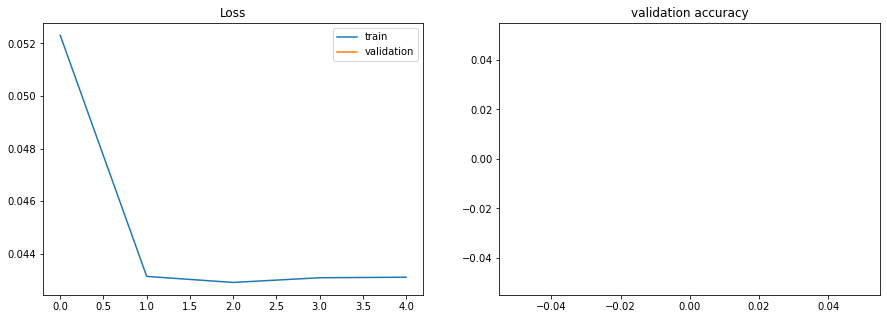

In [10]:
plot_train(vae_loss, [], [])

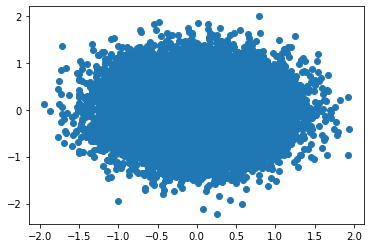

In [11]:
plot_latent(loader, model, False)

In [18]:
torch.save(model, './models/VAE_Behavior_5_epoch.pth')

# Metrics

In [12]:
from common.metrics import *

In [13]:
mean = torch.zeros(2)  # mean of the distribution
cov = torch.eye(2)  # covariance matrix of the distribution
rand_vec = (torch.randn(2) @ cov + mean)

In [14]:
generated_behavior = model.decoder(rand_vec).detach().numpy()

In [15]:
min_dist = behavior_dist(generated_behavior, loader)

In [16]:
print(f'min dist to real sample vector is {min_dist}')

min dist to real sample vector is 10.830937385559082
